<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import gdown
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import train_test_split

#from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=2db0984e-d921-4705-8142-32882619ab21
To: /content/dataset.csv
100%|██████████| 110M/110M [00:02<00:00, 43.9MB/s]


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
no. of data sample : 60000
Training data shape: (48000, 784)
Test data shape: (12000, 784)


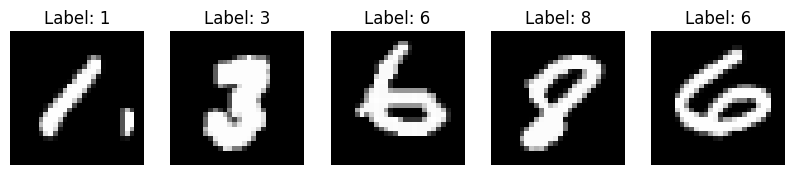

In [2]:
# file import from derive
file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
url = f"https://drive.google.com/uc?id={file_id}"

# downloading file
output = "dataset.csv"
gdown.download(url, output, quiet=False)

# dataframe formation
df = pd.read_csv(output, header=None)

print(df.head())

# making y = label(1st column) and x = row (other column).
y = df.iloc[:, 0].values  # Labels
X = df.iloc[:, 1:].values  # Features (pixel values)

# normalize pixel values (0-255 → 0-1)
X = X / 255.0

# dataset size
total_samples = X.shape[0]
print(f"no. of data sample : {total_samples}")

# logic for spliting
train_ratio = 0.8  # train = 80% and test = 20%
train_size = int(total_samples * train_ratio)
test_size = total_samples - train_size

# spliting by sklearn and also i make sure that split is balance by using 'startify = y'
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=42
)

# shape of train and test
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# displaying some images.|
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")

plt.show()

### **Entropy Definition:**  
Entropy is a measure of **uncertainty** or **randomness** in a system. In information theory, it represents the average amount of information (or surprise) in a message or dataset.  

### **Entropy Formula:**  
For a discrete random variable \( X \) with possible outcomes \( x_i \) and probabilities \( P(x_i) \), the entropy is given by:  

\[
H(X) = - ∑P(x_i)log_2 P(x_i)
\]


### **Explanation:**
- \( H(X) \) = Entropy (in bits if log base 2 is used)  
- \( P(x_i) \) = Probability of outcome \( x_i \)  
- \( log_2 P(x_i) ) = Information content of \( x_i \)  


The function `best_split(X, y)` finds the optimal feature and threshold for splitting data in a decision tree by maximizing information gain.  

### **Formula for Information Gain:**  
IG = H(Y) - [(Size of left split / Total size) * H(Y_L) + (Size of right split / Total size) * H(Y_R)]
where:  
- \( H(Y) \) = Entropy of the entire dataset  
- \( H(Y_L) \) = Entropy of the left split  
- \( H(Y_R) \) = Entropy of the right split  
- \( |Y_L| \), \( |Y_R| \) = Number of samples in left and right splits  
- \( |Y| \) = Total number of samples  

The function iterates through all features and thresholds, calculates entropy before and after the split, and selects the split with the highest **Information Gain (IG)**.

In [3]:
# Define entropy function
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

# Find best split
def best_split(X, y):
    best_feature, best_threshold, best_gain = None, None, 0
    for feature in range(X.shape[1]):
        values = np.unique(X[:, feature])
        for threshold in values:
            left_mask = X[:, feature] < threshold
            right_mask = ~left_mask
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue
            left_entropy = entropy(y[left_mask])
            right_entropy = entropy(y[right_mask])
            gain = entropy(y) - (np.sum(left_mask) / len(y)) * left_entropy - (np.sum(right_mask) / len(y)) * right_entropy
            if gain > best_gain:
                best_feature, best_threshold, best_gain = feature, threshold, gain
    return best_feature, best_threshold


The code builds a Decision Tree Classifier recursively:

**Node Class:** Defines a tree node with attributes like feature, threshold, left/right children, and class value (for leaf nodes).

**Build Tree Function:**

If all labels are the same → Return a leaf node.

If max depth is reached → Return the majority class.

Find the best split using best_split().

If no split is found → Return majority class.

Otherwise, split the data and recursively build left and right subtrees.

This process continues until stopping conditions are met.

In [4]:
# Define Decision Tree Node class
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# Build decision tree
def build_tree(X, y, depth=0, max_depth=10):
    if len(np.unique(y)) == 1:
        return Node(value=np.unique(y)[0])
    if depth >= max_depth:
        return Node(value=np.bincount(y).argmax())
    feature, threshold = best_split(X, y)
    if feature is None:
        return Node(value=np.bincount(y).argmax())
    left_mask = X[:, feature] < threshold
    right_mask = ~left_mask
    left_subtree = build_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
    right_subtree = build_tree(X[right_mask], y[right_mask], depth + 1, max_depth)
    return Node(feature=feature, threshold=threshold, left=left_subtree, right=right_subtree)


**predict(tree, X) Function:** Traverses the tree for each sample in X, following feature thresholds, until a leaf node is reached, and returns predictions.

**Training the Tree:** build_tree(X_train, y_train, max_depth=10) builds a decision tree from training data.

**Making Predictions:** predict(tree, X_test) predicts labels for test data using the trained tree.

In [5]:
# Predict function
def predict(tree, X):
    predictions = []
    for sample in X:
        node = tree
        while node.left or node.right:
            if sample[node.feature] < node.threshold:
                node = node.left
            else:
                node = node.right
        predictions.append(node.value)
    return np.array(predictions)

# Train Decision Tree
tree = build_tree(X_train, y_train, max_depth=10)

# Make Predictions
y_pred = predict(tree, X_test)


**Accuracy:** Measures the percentage of correctly predicted labels.

**Precision:** Indicates how many predicted positives are actually correct.

**Recall:** Shows how many actual positives were correctly identified.

**F1 Score:** Harmonic mean of precision and recall, balancing both.

In [7]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted') * 100
    recall = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100

    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")

evaluate_model(y_test, y_pred)

Precision: 86.30%
Recall: 86.33%
F1 Score: 86.30%



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1185
           1       0.94      0.95      0.95      1348
           2       0.84      0.86      0.85      1192
           3       0.82      0.83      0.82      1226
           4       0.83      0.85      0.84      1168
           5       0.82      0.77      0.79      1084
           6       0.91      0.88      0.89      1184
           7       0.89      0.90      0.90      1253
           8       0.82      0.80      0.81      1170
           9       0.82      0.82      0.82      1190

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



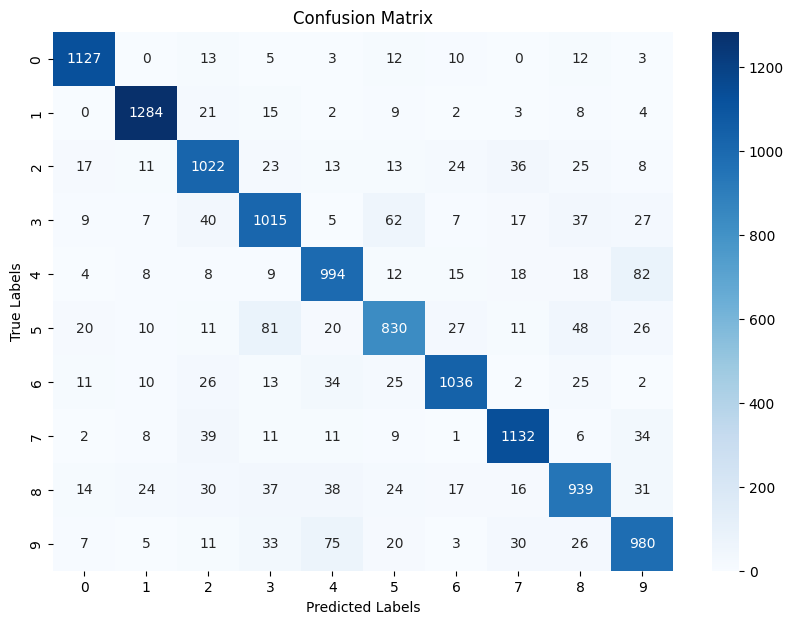

In [9]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [14]:

# overall accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"\nAccuracy: {accuracy:.4f}")


Accuracy: 0.8632


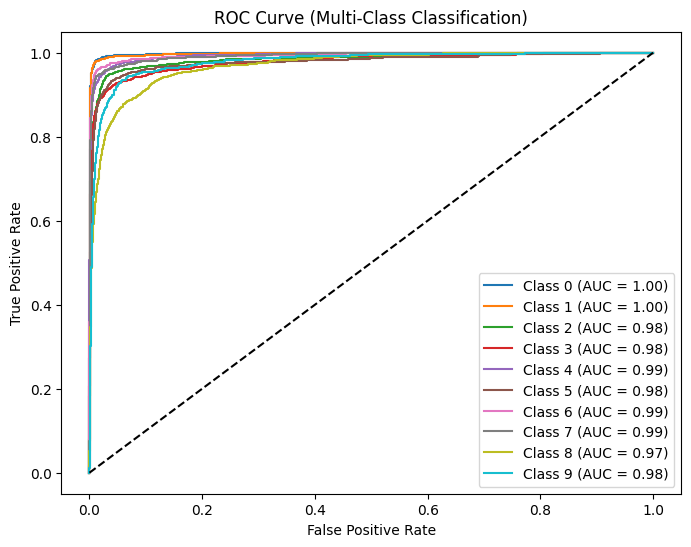

In [10]:
# Convert labels to one-hot encoding for multi-class ROC
y_train_bin = label_binarize(y_train, classes=np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_train_bin.shape[1]

# Train a One-vs-Rest Logistic Regression Model
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, y_train_bin)

# Get probability predictions
y_score = clf.predict_proba(X_test)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc:.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multi-Class Classification)")
plt.legend()
plt.show()


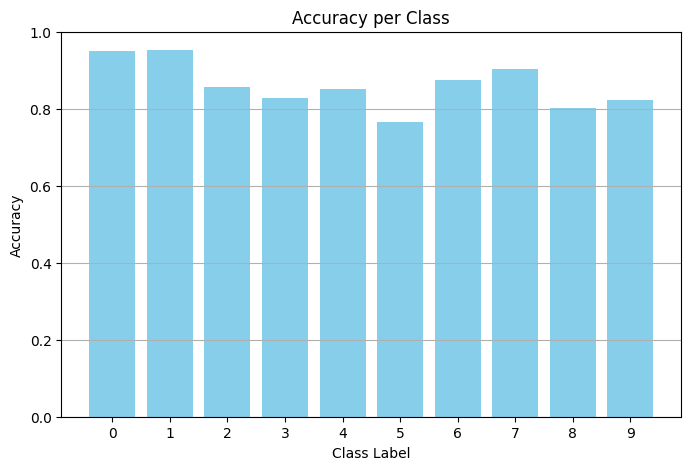

In [11]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute Accuracy per Class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_accuracy = np.nan_to_num(class_accuracy)  # Replace NaN with 0 for empty classes

# Plot Accuracy per Class
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_accuracy)), class_accuracy, color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy per Class")
plt.xticks(range(len(class_accuracy)))
plt.grid(axis="y")
plt.show()

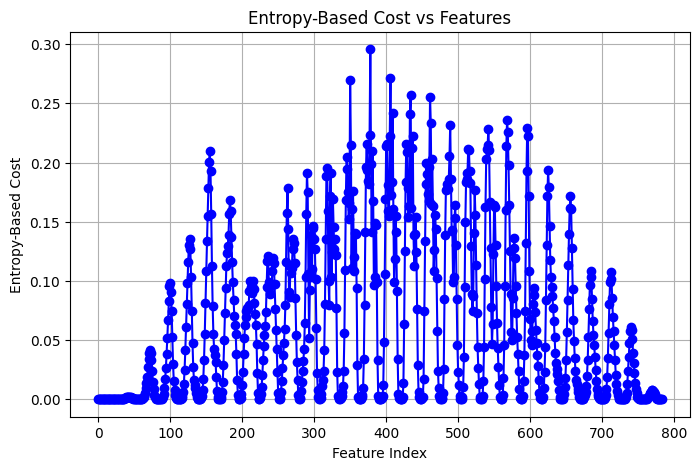

In [12]:
import matplotlib.pyplot as plt

def plot_entropy_cost(X, y):
    features = range(X.shape[1])  # Feature indexes
    costs = []  # Store entropy-based costs for each feature

    for feature in features:
        feature_values = np.unique(X[:, feature])
        entropy_values = []

        for threshold in feature_values:
            left_mask = X[:, feature] < threshold
            right_mask = ~left_mask

            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue  # Skip empty splits

            left_entropy = entropy(y[left_mask])
            right_entropy = entropy(y[right_mask])
            weighted_entropy = (np.sum(left_mask) / len(y)) * left_entropy + \
                               (np.sum(right_mask) / len(y)) * right_entropy

            entropy_values.append(entropy(y) - weighted_entropy)  # Information Gain

        costs.append(np.mean(entropy_values) if entropy_values else 0)  # Avg cost per feature

    # Plot the graph
    plt.figure(figsize=(8, 5))
    plt.plot(features, costs, marker='o', linestyle='-', color='b')
    plt.xlabel("Feature Index")
    plt.ylabel("Entropy-Based Cost")
    plt.title("Entropy-Based Cost vs Features")
    plt.grid()
    plt.show()

# Example Usage
plot_entropy_cost(X_train, y_train)



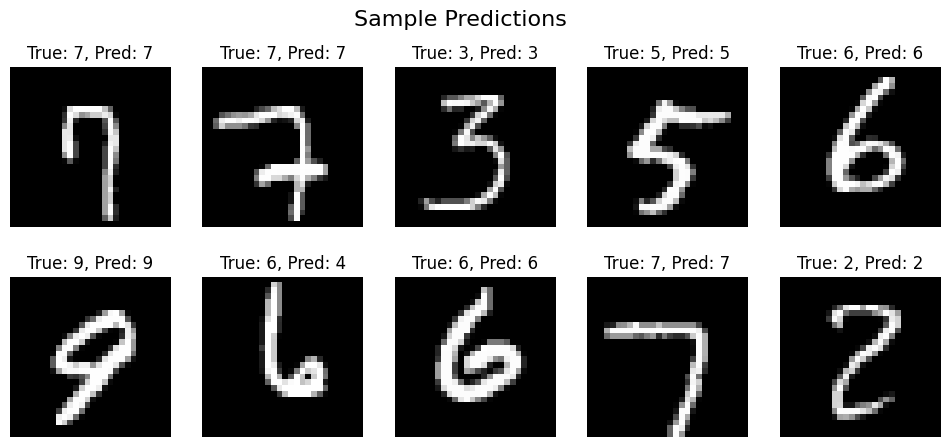

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Sample Predictions", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test[i]}, Pred: {y_pred[i]}")
    ax.axis("off")

plt.show()
